In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from math import log10
%matplotlib inline
start_time = pd.datetime.now()
import copy
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn import metrics

<ipython-input-1-c5a8c5df4780>:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start_time = pd.datetime.now()


In [2]:
data = pd.read_csv('card transactions.csv', usecols = ['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description', 'Merch state',
                                                        'Merch zip', 'Transtype', 'Amount', 'Fraud'])

In [3]:
data['Date'] = pd.to_datetime(data['Date'])

In [4]:
data.dtypes

Recnum                        int64
Cardnum                       int64
Date                 datetime64[ns]
Merchnum                     object
Merch description            object
Merch state                  object
Merch zip                   float64
Transtype                    object
Amount                      float64
Fraud                         int64
dtype: object

In [5]:
data['Cardnum']=data['Cardnum'].astype('str')
data['Merchnum']=np.where((data['Merchnum']=='NaN') | (data['Merchnum']=='0'),np.nan,data['Merchnum'])
data['Merch zip']=data['Merch zip'].fillna(0).apply(lambda x:int(x))
data['Merch zip']=data['Merch zip'].apply(lambda x:str(x))
data['Merch zip']=np.where(data['Merch zip']=='0',np.nan,data['Merch zip'])
data=data.loc[data['Transtype']=='P',]
data = data.loc[data['Amount']<100000,]
data['Merch state'].fillna('Unknown',inplace=True)
data['Merch zip'].fillna('Unknown',inplace=True)
data['Merchnum'].fillna('Unknown',inplace=True)

In [6]:
merchdes_merchnum = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_merchnum :
        merchdes_merchnum[merchdes] = data.loc[index, 'Merchnum']
# fill in by mapping with Merch description
data['Merchnum'] = data['Merchnum'].fillna(data['Merch description'].map(merchdes_merchnum))

# assign unknown for adjustments transactions
data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [7]:
zip_state = {}
for index, zip5 in data[data['Merch zip'].notnull()]['Merch zip'].items():
    if zip5 not in zip_state:
        zip_state[zip5] = data.loc[index, 'Merch state']
        
zip_state['00926'] = 'PR'
zip_state['00929'] = 'PR'
zip_state['00934'] = 'PR'
zip_state['00902'] = 'PR'
zip_state['00738'] = 'PR'
zip_state['90805'] = 'CA'
zip_state['76302'] = 'TX'
zip_state['00914'] = 'PR'
zip_state['95461'] = 'CA'
zip_state['00680'] = 'PR'
zip_state['00623'] = 'PR'
zip_state['00726'] = 'PR'
zip_state['00936'] = 'PR'
zip_state['12108'] = 'NY'
zip_state['00791'] = 'PR'
zip_state['00907'] = 'PR'
zip_state['00922'] = 'PR'
zip_state['00920'] = 'PR'
zip_state['00801'] = 'VI'
zip_state['31040'] = 'GA'
zip_state['41160'] = 'KY'
zip_state['00681'] = 'PR'

merchnum_state = {}
for index, merchnum in data[data['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_state:
        merchnum_state[merchnum] = data.loc[index, 'Merch state']
        
merchdes_state = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_state:
        merchdes_state[merchdes] = data.loc[index, 'Merch state']

In [8]:
# fill in by mapping with zip, merchnum and merch description
data['Merch state'] = data['Merch state'].fillna(data['Merch zip'].map(zip_state))
data['Merch state'] = data['Merch state'].fillna(data['Merchnum'].map(merchnum_state))
data['Merch state'] = data['Merch state'].fillna(data['Merch description'].map(merchdes_state))

# assign unknown for adjustments transactions
data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [9]:
merchnum_zip = {}
for index, merchnum in data[data['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_zip :
        merchnum_zip [merchnum] = data.loc[index, 'Merch zip']

merchdes_zip = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_zip :
        merchdes_zip [merchdes] = data.loc[index, 'Merch zip']

In [10]:
# fill in by mapping with merchnum and merch description
data['Merch zip'] = data['Merch zip'].fillna(data['Merchnum'].map(merchnum_zip))
data['Merch zip'] = data['Merch zip'].fillna(data['Merch description'].map(merchdes_zip))

# assign unknown for adjustments transactions
data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

# fill the rest with unknown
data = data.fillna('unknown')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96397 non-null  int64         
 1   Cardnum            96397 non-null  object        
 2   Date               96397 non-null  datetime64[ns]
 3   Merchnum           96397 non-null  object        
 4   Merch description  96397 non-null  object        
 5   Merch state        96397 non-null  object        
 6   Merch zip          96397 non-null  object        
 7   Transtype          96397 non-null  object        
 8   Amount             96397 non-null  float64       
 9   Fraud              96397 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 10.1+ MB


In [11]:
data.to_csv("card_no_na.csv")

In [12]:
df1=pd.read_csv('card_no_na.csv',index_col=0)

In [13]:
df1.Date=pd.to_datetime(df1.Date)
df1['check_record']=df1['Recnum']
df1['check_date']=df1['Date']

In [14]:
df1.shape

(96397, 12)

In [15]:
#create entities:
## card at this merchant
df1['card_merch']=df1['Cardnum'].map(str)+df1['Merchnum'].map(str)
## card in this zip code
df1['card_zip']=df1['Cardnum'].map(str)+df1['Merch zip'].map(str)
## card in this state
df1['card_state']=df1['Cardnum'].map(str)+df1['Merch state'].map(str)
## merchant in this zip code
df1['merch_zip']=df1['Merchnum'].map(str)+df1['Merch zip'].map(str)
## merchant in this state
df1['merch_state']=df1['Merchnum'].map(str)+df1['Merch state'].map(str)
## card for this description
df1['card_desc']=df1['Cardnum'].map(str)+df1['Merch description'].map(str)
## merchant for this description
df1['merch_desc']=df1['Merchnum'].map(str)+df1['Merch description'].map(str)

In [16]:
entities=['Cardnum', 'Merchnum','card_merch', 'card_zip', 'card_state','merch_zip', 'merch_state', 'card_desc', 'merch_desc']

In [17]:
df1.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud',
       'check_record', 'check_date', 'card_merch', 'card_zip', 'card_state',
       'merch_zip', 'merch_state', 'card_desc', 'merch_desc'],
      dtype='object')

In [18]:
df1.shape

(96397, 19)

In [19]:
df2=copy.copy(df1)

In [20]:
df2.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud',
       'check_record', 'check_date', 'card_merch', 'card_zip', 'card_state',
       'merch_zip', 'merch_state', 'card_desc', 'merch_desc'],
      dtype='object')

In [21]:
# Days-since Variables

for entity in entities:
    df_l = df1[['Recnum', 'Date', entity]]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]   
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)
    # Day-since variables
    temp1 = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']]\
                                                   .groupby('Recnum')[['Date', 'check_date']].last()
    mapper = (temp1.Date - temp1.check_date).dt.days
    df2[entity + '_day_since'] = df2.Recnum.map(mapper)
    df2[entity + '_day_since'].fillna((df2.Date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)

In [22]:
df2.shape

(96397, 28)

In [24]:
# Frequency Variables
time_range=[0,1,3,7,14,30]
for entity in entities:
    df_l = df1[['Recnum', 'Date', entity]]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]   
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)
    for time in time_range:
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]       
        col_name = entity + '_count_' + str(time)    
        mapper2 = temp2.groupby('Recnum')[entity].count()      
        df2[col_name] = df2.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')       
        df2[entity + '_avg_' + str(time)] = df2.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        df2[entity + '_max_' + str(time)] = df2.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        df2[entity + '_med_' + str(time)] = df2.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        df2[entity + '_total_' + str(time)] = df2.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        df2[entity + '_actual/avg_' + str(time)] = df2['Amount'] / df2[entity + '_avg_' + str(time)]
        df2[entity + '_actual/max_' + str(time)] = df2['Amount'] / df2[entity + '_max_' + str(time)]
        df2[entity + '_actual/med_' + str(time)] = df2['Amount'] / df2[entity + '_med_' + str(time)]
        df2[entity + '_actual/toal_' + str(time)] = df2['Amount'] / df2[entity + '_total_' + str(time)]       
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')

Cardnum_count_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_count_1 ---> Done
Cardnum amount variables over past 1 ---> Done
Cardnum_count_3 ---> Done
Cardnum amount variables over past 3 ---> Done
Cardnum_count_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_count_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_count_30 ---> Done
Cardnum amount variables over past 30 ---> Done
Merchnum_count_0 ---> Done
Merchnum amount variables over past 0 ---> Done
Merchnum_count_1 ---> Done
Merchnum amount variables over past 1 ---> Done
Merchnum_count_3 ---> Done
Merchnum amount variables over past 3 ---> Done
Merchnum_count_7 ---> Done
Merchnum amount variables over past 7 ---> Done
Merchnum_count_14 ---> Done
Merchnum amount variables over past 14 ---> Done
Merchnum_count_30 ---> Done
Merchnum amount variables over past 30 ---> Done
card_merch_count_0 ---> Done
card_merch amount variables over past 0 ---> Done
card_merch_count_1 ---> D

In [25]:
df2.shape

(96397, 514)

In [26]:
df2.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud',
       ...
       'merch_desc_actual/toal_14', 'merch_desc_count_30', 'merch_desc_avg_30',
       'merch_desc_max_30', 'merch_desc_med_30', 'merch_desc_total_30',
       'merch_desc_actual/avg_30', 'merch_desc_actual/max_30',
       'merch_desc_actual/med_30', 'merch_desc_actual/toal_30'],
      dtype='object', length=514)

In [27]:
# Velocity Variables
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30']:
            df2[ent + '_count_' + d + '_by_' + dd] =\
            df2[ent + '_count_' + d]/(df2[ent + '_count_' + dd])/float(dd)

In [28]:
df2.shape

(96397, 568)

In [29]:
df2.to_csv('df2.csv')

In [30]:
table = df2.iloc[:,19:568]

In [31]:
table

,Cardnum_day_since,Merchnum_day_since,card_merch_day_since,card_zip_day_since,card_state_day_since,merch_zip_day_since,merch_state_day_since,card_desc_day_since,merch_desc_day_since,Cardnum_count_0,...,card_desc_count_0_by_30,card_desc_count_1_by_7,card_desc_count_1_by_14,card_desc_count_1_by_30,merch_desc_count_0_by_7,merch_desc_count_0_by_14,merch_desc_count_0_by_30,merch_desc_count_1_by_7,merch_desc_count_1_by_14,merch_desc_count_1_by_30
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
3,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96748,37.0,365.0,365.0,37.0,37.0,365.0,365.0,365.0,365.0,1,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
96749,0.0,9.0,11.0,11.0,2.0,9.0,9.0,11.0,9.0,2,...,0.016667,0.142857,0.035714,0.016667,0.142857,0.014286,0.004762,0.142857,0.014286,0.004762
96750,1.0,0.0,365.0,365.0,1.0,0.0,0.0,365.0,0.0,1,...,0.033333,0.142857,0.071429,0.033333,0.095238,0.040816,0.006667,0.095238,0.040816,0.006667
96751,9.0,1.0,26.0,26.0,26.0,1.0,1.0,26.0,1.0,1,...,0.011111,0.142857,0.071429,0.011111,0.023810,0.005495,0.000725,0.095238,0.021978,0.002899


In [32]:
t = table.describe().transpose()

In [33]:
t

,count,mean,std,min,25%,50%,75%,max
Cardnum_day_since,96397.0,5.436902,17.235291,0.000000,0.000000,1.000000,5.000000,357.000000
Merchnum_day_since,96397.0,29.878378,66.350151,0.000000,0.000000,2.000000,18.000000,365.000000
card_merch_day_since,96397.0,81.229001,99.630527,0.000000,3.000000,32.000000,136.000000,365.000000
card_zip_day_since,96397.0,70.823096,93.163306,0.000000,2.000000,24.000000,110.000000,365.000000
card_state_day_since,96397.0,38.469237,67.630924,0.000000,1.000000,8.000000,40.000000,365.000000
...,...,...,...,...,...,...,...,...
merch_desc_count_0_by_14,96397.0,0.039778,0.027847,0.000364,0.011905,0.035714,0.071429,0.071429
merch_desc_count_0_by_30,96397.0,0.015685,0.013191,0.000121,0.003175,0.011111,0.033333,0.033333
merch_desc_count_1_by_7,96397.0,0.101756,0.047182,0.001043,0.057143,0.142857,0.142857,0.142857
merch_desc_count_1_by_14,96397.0,0.043395,0.026410,0.000364,0.017857,0.035714,0.071429,0.071429


In [34]:
a=set(df2.columns)
b=set(df1.columns)-set(['Amount'])
numeric_variables=list(a-b)
t_1 = df2[numeric_variables]

In [35]:
table_1 = t_1.describe().transpose()

In [36]:
t.to_csv('variable_table_529.csv')

In [37]:
table_1.to_csv('variable_table_550.csv')

In [38]:
df2.dtypes

Recnum                               int64
Cardnum                              int64
Date                        datetime64[ns]
Merchnum                            object
Merch description                   object
                                 ...      
merch_desc_count_0_by_14           float64
merch_desc_count_0_by_30           float64
merch_desc_count_1_by_7            float64
merch_desc_count_1_by_14           float64
merch_desc_count_1_by_30           float64
Length: 568, dtype: object

In [19]:
df2=pd.read_csv("df2.csv",index_col=0)

In [20]:
df2.Date=pd.to_datetime(df2.Date)

In [21]:
#df2 = df2.iloc[:,19:568]

In [22]:
df2=df2.drop(columns=['card_merch', 'card_zip', 'card_state','merch_zip', 'merch_state', 'card_desc', 'merch_desc'])
a=set(df2.columns)
b=set(df1.columns)
numeric_variables=list(a-b)

In [23]:
df2.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud',
       ...
       'card_desc_count_0_by_30', 'card_desc_count_1_by_7',
       'card_desc_count_1_by_14', 'card_desc_count_1_by_30',
       'merch_desc_count_0_by_7', 'merch_desc_count_0_by_14',
       'merch_desc_count_0_by_30', 'merch_desc_count_1_by_7',
       'merch_desc_count_1_by_14', 'merch_desc_count_1_by_30'],
      dtype='object', length=561)

In [24]:
df3=copy.copy(df2).reset_index(drop=True)

In [25]:
standardizer=StandardScaler()
df3[numeric_variables]= standardizer.fit_transform(df3[numeric_variables])

In [26]:
df3['Weekday']=df3.Date.dt.weekday+1
df3['Month']=df3.Date.dt.month
mask = (df3['Month'] >= 1) & (df3['Month'] <= 8)
mask2 = (df3['Month'] >= 9) & (df3['Month'] <= 12)
traintest = df3.loc[mask]

OOTvali=df3.loc[mask2] # real test data

In [27]:
c=4
nmid=15
y_avg=traintest['Fraud'].mean()
y_weekday_avg=traintest.groupby('Weekday')['Fraud'].mean()
number_instance=traintest.groupby('Weekday').size()
y_smooth=y_avg+(y_weekday_avg-y_avg)/(1+np.exp(-(number_instance-nmid)/c))
traintest['Weekday_risk']=traintest['Weekday'].map(y_smooth)

<ipython-input-27-d3f4bdda0813>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traintest['Weekday_risk']=traintest['Weekday'].map(y_smooth)


In [28]:
y_state_avg=traintest.groupby('Merch state')['Fraud'].mean()
number_instance_state=traintest.groupby('Merch state').size()
y_state_smooth=y_avg+(y_state_avg-y_avg)/(1+np.exp(-(number_instance_state-nmid)/c))
traintest['state_risk']=traintest['Merch state'].map(y_state_smooth)

<ipython-input-28-161542157b7c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traintest['state_risk']=traintest['Merch state'].map(y_state_smooth)


In [29]:
mapper=traintest.groupby('Merch state')['state_risk'].mean()
OOTvali['state_risk']=OOTvali['Merch state'].map(mapper)

<ipython-input-29-593c5a038518>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOTvali['state_risk']=OOTvali['Merch state'].map(mapper)


In [30]:
mapper2=traintest.groupby('Weekday')['Weekday_risk'].mean()
OOTvali['Weekday_risk']=OOTvali['Weekday'].map(mapper2)

<ipython-input-30-e2afb0713db4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOTvali['Weekday_risk']=OOTvali['Weekday'].map(mapper2)


Text(0, 0.5, 'risk_prop')

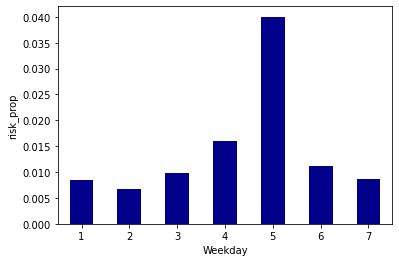

In [31]:
#two risk table variables

mapper2.plot.bar(color='darkblue')
plt.xticks(rotation=0)
plt.ylabel("risk_prop")

Text(0, 0.5, 'risk_prop')

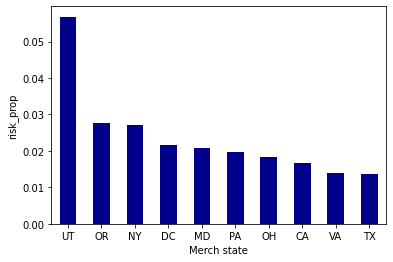

In [32]:

mapper.sort_values(ascending=False).head(10).plot.bar(color='darkblue')
plt.xticks(rotation=0)
plt.ylabel("risk_prop")

In [33]:
print(traintest['state_risk'].min())
print(traintest['state_risk'].max())
print(traintest['state_risk'].mean())
print(traintest['state_risk'].std())

0.0
0.05679862306368331
0.01018678181090242
0.009143733709251197


In [34]:
print(traintest['Weekday_risk'].min())
print(traintest['Weekday_risk'].max())
print(traintest['Weekday_risk'].mean())
print(traintest['Weekday_risk'].std())

0.006651570902915369
0.0400219298245614
0.010181618051733628
0.005494838703311417


In [35]:
traintest_keep=traintest.drop(columns=['Weekday','Month','Recnum', 'Cardnum', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount','check_record','check_date'])

In [35]:
traintest_keep.to_csv('traintest.csv')
OOTvali.to_csv('ootdata.csv')